# Constrained Likelihood

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#|default_exp likelihood

In [5]:
#|export
import jax
import jax.numpy as jnp
from jax import (jit, vmap)
import genjax
from genjax import gen, choice_map, vector_choice_map
import matplotlib.pyplot as plt
import numpy as np
import bayes3d
from bayes3d._mkl.utils import *

console = genjax.pretty(show_locals=False)
key     = jax.random.PRNGKey(0)

In [6]:
#|export
import genjax._src.generative_functions.distributions.tensorflow_probability as gentfp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

uniform = genjax.tfp_uniform

truncnormal = gentfp.TFPDistribution(
    lambda mu, sig, low, high: tfd.TruncatedNormal(mu, sig, low, high));

normal = gentfp.TFPDistribution(
    lambda mu, sig: tfd.Normal(mu, sig));

diagnormal = gentfp.TFPDistribution(
    lambda mus, sigs: tfd.MultivariateNormalDiag(mus, sigs));


mixture_of_diagnormals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.MultivariateNormalDiag(mus, sig * jnp.ones_like(mus))))

mixture_of_normals = gentfp.TFPDistribution(
    lambda ws, mus, sig: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.Normal(mus, sig * jnp.ones_like(mus))))


mixture_of_truncnormals = gentfp.TFPDistribution(
    lambda ws, mus, sigs, lows, highs: tfd.MixtureSameFamily(
        tfd.Categorical(ws),
        tfd.TruncatedNormal(mus, sigs, lows, highs)))

In [7]:
#|export
from scipy.stats import truncnorm as scipy_truncnormal

normal_logpdf    = jax.scipy.stats.norm.logpdf
truncnorm_logpdf = jax.scipy.stats.truncnorm.logpdf
truncnorm_pdf    = jax.scipy.stats.truncnorm.pdf


In [8]:
# This function is adapted from `bayes3d.likelihood.gausssian_mixture_vectorize`
# which computes the pixel-wise logprobs in the 3dp3 likelihood.
def threeDP3_logpdf(x, ys, variance, outlier, vol):
    m     = len(ys)
    diffs = x - ys
    logps = jax.scipy.special.logsumexp( 
        jax.scipy.stats.norm.logpdf(
            diffs,
            loc=0.0,
            scale=jnp.sqrt(variance)
        ).sum(-1) - jnp.log(m)
    )
    return jnp.logaddexp(jnp.log(1.0 - outlier) + logps, jnp.log(outlier) - jnp.log(vol))

## 1D Mixture Components

In [13]:
#|export
def get_1d_mixture_components(x, ys, sig):
    """Returns 1d mixture components and thier unnormalized weights."""
    # 1D-Mixture components and value to evaluate.
    # These are given by the distances ALONG ray through `x`
    d  = jnp.linalg.norm(x, axis=-1)
    ds = ys @ x / d
    
    # 1D-Mixture weights.
    # First compute the distances TO ray through `x`
    # and then transforming them appropriately.
    ws_ = jnp.linalg.norm(ds[...,None] * x/d - ys, axis=-1)
    ws  = normal_logpdf(ws_, loc=0.0, scale=sig) + normal_logpdf(0.0, loc=0.0, scale=sig)

    return d, ds, ws

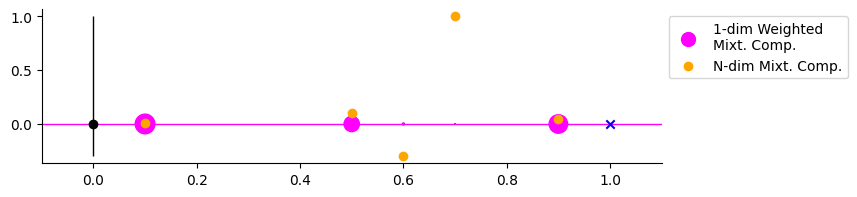

In [22]:
sig  = .1
zmax = 1.

xs = zmax*jnp.linspace(0.0,1.0,1000)[:,None]*jnp.array([0.0, 0.0, 1.0])
x  = xs[-1]
ys = zmax*jnp.array([ 
    [.01, 0., .1],
    [0.1, 0, .5],
    [-.3, 0, .6],
    [1, 0, .7],
    [.05, 0, .9],
])

d, ds, ws = get_1d_mixture_components(x, ys, sig)
ws = ws - logsumexp(ws, axis=-1)

# ------------------------------
fig, ax = plt.subplots(1,1, figsize=(8,2), sharex=True)
ax.set_xlim(-0.1*zmax,1.1*zmax)
ax.scatter(ds, jnp.zeros(len(ds)),  s=jnp.exp(ws)*500, c="magenta", label="1-dim Weighted\nMixt. Comp.")
ax.scatter(d, x[0],marker="x", c="blue");
ax.hlines(0, -0.1*zmax,1.1*zmax, color="magenta", zorder=-1, linewidth=1.)
ax.scatter(ys[:,2], ys[:,0], c="orange", label="N-dim Mixt. Comp.")
ax.vlines(0, jnp.min(ys[:,0]), jnp.max(ys[:,0]), color="k", zorder=-1, linewidth=1.)
ax.scatter(0,0, c="k")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1.))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Reality Checks 

Comparing the constrained 1d mixture with restricted 3d mixture and Nishad's 3dp3 likelihood.

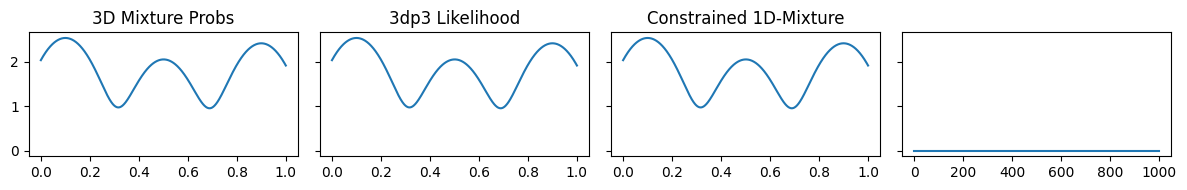

In [23]:
sig = .1

# Baseline of 3D-Mixture
ws0 = jnp.zeros(len(ys)) - jnp.log(len(ys))
ps0 = vmap(lambda x: 
            mixture_of_diagnormals.logpdf(x, ws0, ys, sig)
      )(xs)

# 3dp3 Likelihood
ps1 = vmap(lambda x: threeDP3_logpdf(x, ys, sig**2, 0.0, 1.0))(xs)


# Constrained 1D-Mixture
_, ds, ws = get_1d_mixture_components(xs[-1], ys, sig)
ps2 = vmap(lambda x: 
            mixture_of_normals.logpdf(x, ws, ds, sig)
      )(jnp.linalg.norm(xs, axis=-1))

offset = logsumexp(ws) - jnp.log(len(ws))


# ------------------------------
fig, axs = plt.subplots(1,4, figsize=(12,2), sharey=True)
axs[0].set_title("3D Mixture Probs")
axs[0].plot(jnp.linalg.norm(xs, axis=-1), ps0)
axs[1].set_title("3dp3 Likelihood")
axs[1].plot(jnp.linalg.norm(xs, axis=-1), ps1)
axs[2].set_title("Constrained 1D-Mixture")
axs[2].plot(jnp.linalg.norm(xs, axis=-1), ps2 + offset)
axs[3].plot(ps0 - ps2- offset);
fig.tight_layout()

In [25]:
sig = 0.2
x = jnp.array(np.random.randn(3))
y = jnp.array(np.random.randn(3))

d = jnp.linalg.norm(x)
y_ = y@x/d
w_ = jnp.linalg.norm(y_*x/d - y)


(
    diagnormal.logpdf(x, y, sig*jnp.ones_like(y)),
    normal.logpdf(d, y_, sig) + normal.logpdf(w_, 0, sig) + normal.logpdf(0.0, 0.0, sig),
)

(Array(-135.55336, dtype=float32), Array(-135.55336, dtype=float32))

In [28]:
sig = 0.2

x  = jnp.array(np.random.randn(3))
ys = jnp.array(np.random.randn(20,3))

d   = jnp.linalg.norm(x)
ys_ = jnp.dot(ys,x) / d
ws_ = jnp.linalg.norm(ys_[:,None]*x[None]/d - ys, axis=-1)
ws_ = normal_logpdf(ws_, 0.0, sig) + normal_logpdf(0.0, 0.0, sig)


(
    mixture_of_diagnormals.logpdf(x, jnp.zeros(len(ys)), ys, sig),

    logsumexp(jnp.array([
        diagnormal.logpdf(x, y, sig*jnp.ones_like(y)) for y in ys
    ])) - jnp.log(len(ys)),

    logsumexp(jnp.array([
        normal_logpdf(d, y_, sig) + w_ for y_,w_ in zip(ys_, ws_)
    ])) - jnp.log(len(ys)),

    mixture_of_normals.logpdf(d, ws_, ys_, sig) + logsumexp(ws_) - jnp.log(len(ys))
)

(
    Array(-1.1080301, dtype=float32),
    Array(-1.1080301, dtype=float32),
    Array(-1.1080303, dtype=float32),
    Array(-1.1080303, dtype=float32)
)

## Reality check with images

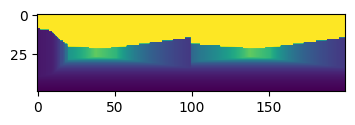

In [56]:
# The data was created in the "Likelihood Test Data" notebook.
suff = "50x100"
Xs = jnp.load(f"./data/test_Xs_{suff}.npy")
Ys = jnp.load(f"./data/test_Ys_{suff}.npy")
ps = jnp.load(f"./data/test_ps_{suff}.npy")


plt.figure(figsize=(4,1))
plt.imshow(jnp.concatenate([Xs[10,:,:,2],Ys[10,:,:,2]], axis=1), vmax=6);

## Constrained Likelihood

In [142]:
#|export
# Some helper to keep code concise
min = jnp.minimum
max = jnp.maximum


def dslice(X, i, j, w):     
    m = 2*w + 1
    return  jax.lax.dynamic_slice(X, (i, j, 0), (m, m, 3))   


def pad(X, w, val=-100.0):
    return jax.lax.pad(X,  val, ((w,w,0),(w,w,0),(0,0,0)))


def mix_std(ps, mus, stds):
    """Standard Deviation of a mixture of Gaussians."""
    return jnp.sqrt(jnp.sum(ps*stds**2) + jnp.sum(ps*mus**2) - (jnp.sum(ps*mus))**2)

In [96]:
#|export
# TODO: The input Y should be an array only containing range measruements as well. 
#       For this to work we need to have the pixel vectors (the rays through each pixel)

def make_constrained_model(zmax, w):
    """Returns an untruncated constrained sensor model marginalized over outliers."""    

    pad_val = -100.0

    @genjax.drop_arguments
    @gen
    def _sensor_model_ij(i, j, Y_, sig, outlier):

        # Note that `i,j` are at the edge of the filter window,
        # the Center is offset by `w``
        y  = Y_[i+w,j+w] 
        ys = dslice(Y_, i, j, w).reshape(-1,3)
        
        d, ds, ws = get_1d_mixture_components(y, ys, sig)

        inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                                mixture_of_normals, genjax.tfp_uniform])

        zmax_ = d/y[2]*zmax

        z = inlier_outlier_mix([jnp.log(1.0-outlier), jnp.log(outlier)], (
                                    (ws, ds, sig), 
                                    (0.0, zmax_))) @ "measurement"

        return z * y/d

        
    @gen
    def sensor_model(Y, sig, outlier):   
        """Constrained sensor model."""
        Y_ = pad(Y, w, val=pad_val)

        I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
        I, J = I.ravel(), J.ravel()
                
        
        X = genjax.Map(_sensor_model_ij, (0,0,None,None,None))(I, J, Y_, sig, outlier) @ "X"
        X = X.reshape(Y.shape)

        return X

    return sensor_model

## Baseline Comparison

In [ ]:
from genjax.generative_functions.distributions import ExactDensity
from bayes3d.likelihood import threedp3_likelihood


def make_baseline(zmax, w): 
    return lambda X, Y, sig, outlier: threedp3_likelihood(X, Y, sig**2, outlier, zmax, w)

In [98]:
#  Data created in "Likelihood Test Data" notebook.
suff = "50x100"
Xs = jnp.load(f"./data/test_Xs_{suff}.npy")
Ys = jnp.load(f"./data/test_Ys_{suff}.npy")
ps = jnp.load(f"./data/test_ps_{suff}.npy")

In [99]:
zmax = 100.
w    = 5

baseline = make_baseline(zmax, w)
eval_baseline = jit(vmap(baseline, (None,0,None,None)))

In [100]:
model = make_constrained_model(zmax, w)


def _eval_constrained(X, Y, sig, outlier):
    obs = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  jnp.linalg.norm(X[:,:,:3], axis=-1).reshape(-1)
            }) 
    })
    args = (Y[:,:,:3], sig, outlier)
    w, tr = model.importance(key, obs, args)
    return w


eval_constrained = jit(vmap(_eval_constrained, (None, 0, None, None)))

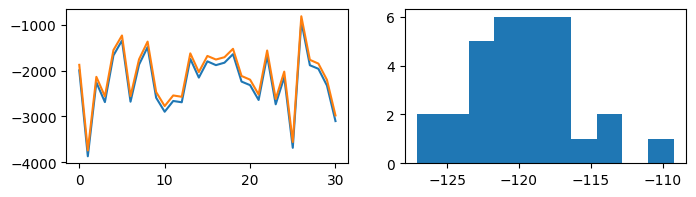

In [101]:
sig     = .2
outlier = 0.0
X = Xs[0,:,:,:3]

a =    eval_baseline(X, Ys, sig, outlier) 
b = eval_constrained(X, Ys, sig, outlier)
# ---------------------------
fig, axs = plt.subplots(1,2, figsize=(8,2))
axs[0].plot(a)
axs[0].plot(b)
axs[1].hist(jnp.array(a)- jnp.array(b));

In [102]:
from functools import partial

def _adjusted_model_ij(i,j, X, Y_, sig, outlier, zmax, w):
    y  = Y_[i+w,j+w,:3] 
    ys = dslice(Y_, i, j, w).reshape(-1,3)

    d, ds, ws = get_1d_mixture_components(y, ys, sig)

    inlier_outlier_mix = genjax.tfp_mixture(genjax.tfp_categorical, [
                        mixture_of_normals, genjax.tfp_uniform])

    x = X[i,j,:3]
    z = jnp.linalg.norm(x)

    logp = inlier_outlier_mix.logpdf(z, 
            [jnp.log(1.0-outlier), jnp.log(outlier)],
            ((ws- logsumexp(ws), ds, sig), (0.0, zmax))
    )
    
    adjustment = logsumexp(ws) - jnp.log(len(ws))

    return logp + adjustment


@partial(jit, static_argnames=['w'])
def eval_adjusted(X, Y, sig, outlier, zmax, w):
    Y_ = pad(Y, w, val=-100.0)
    I, J = jnp.mgrid[:Y.shape[0], :Y.shape[1]]
    I, J = I.ravel(), J.ravel()
    return jnp.sum(vmap(lambda i,j: _adjusted_model_ij(i,j, X, Y_, sig, outlier, zmax, w))(I,J))


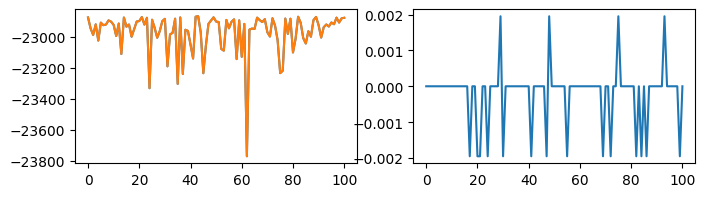

In [104]:
w       = 7
sig     = 1.5
outlier = 0.0
zmax    = 100.0

X = Ys[0,:,:,:3]
a =       [eval_adjusted(X, Y,    sig, outlier, zmax, w) for Y in Ys]
b = [threedp3_likelihood(X, Y, sig**2, outlier, zmax, w) for Y in Ys]


fig, axs = plt.subplots(1,2, figsize=(8,2))
axs[0].plot(a)
axs[0].plot(b)
axs[1].plot(jnp.array(a)- jnp.array(b));